In [1]:
!pip install causalml

In [2]:
from causalml.dataset import make_uplift_classification
from causalml.inference.tree import UpliftTreeClassifier, UpliftRandomForestClassifier
from causalml.inference.tree import uplift_tree_string, uplift_tree_plot
from causalml.metrics import plot_gain

import numpy as np
import pandas as pd
from IPython.display import Image
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

import matplotlib.font_manager as fm
fe = fm.FontEntry(
    fname=r'/usr/share/fonts/truetype/nanum/NanumGothic.ttf', # ttf 파일이 저장되어 있는 경로
    name='NanumGothic')                        # 이 폰트의 원하는 이름 설정
fm.fontManager.ttflist.insert(0, fe)              # Matplotlib에 폰트 추가
plt.rcParams.update({'font.size': 18, 'font.family': 'NanumGothic'}) # 폰트 설정

ERROR:duecredit:Failed to import duecredit due to No module named 'duecredit'


In [3]:
import importlib
print(importlib.metadata.version('causalml'))

0.15.5


## **1. synthetic data를 이용한 uplift tree 모델**

In [4]:
df_ex, x_names_ex = make_uplift_classification()

In [5]:
help(make_uplift_classification)

Help on function make_uplift_classification in module causalml.dataset.classification:

make_uplift_classification(n_samples=1000, treatment_name=['control', 'treatment1', 'treatment2', 'treatment3'], y_name='conversion', n_classification_features=10, n_classification_informative=5, n_classification_redundant=0, n_classification_repeated=0, n_uplift_increase_dict={'treatment1': 2, 'treatment2': 2, 'treatment3': 2}, n_uplift_decrease_dict={'treatment1': 0, 'treatment2': 0, 'treatment3': 0}, delta_uplift_increase_dict={'treatment1': 0.02, 'treatment2': 0.05, 'treatment3': 0.1}, delta_uplift_decrease_dict={'treatment1': 0.0, 'treatment2': 0.0, 'treatment3': 0.0}, n_uplift_increase_mix_informative_dict={'treatment1': 1, 'treatment2': 1, 'treatment3': 1}, n_uplift_decrease_mix_informative_dict={'treatment1': 0, 'treatment2': 0, 'treatment3': 0}, positive_class_proportion=0.5, random_seed=20190101)
    Generate a synthetic dataset for classification uplift modeling problem.
    
    Paramete

In [6]:
df_ex.head()

,treatment_group_key,x1_informative,x2_informative,x3_informative,x4_informative,x5_informative,x6_irrelevant,x7_irrelevant,x8_irrelevant,x9_irrelevant,...,x12_uplift_increase,x13_increase_mix,x14_uplift_increase,x15_uplift_increase,x16_increase_mix,x17_uplift_increase,x18_uplift_increase,x19_increase_mix,conversion,treatment_effect
0,control,-0.542888,1.976361,-0.531359,-2.354211,-0.380629,-2.614321,-0.128893,0.448689,-2.275192,...,-1.315304,0.742654,1.891699,-2.428395,1.541875,-0.817705,-0.610194,-0.591581,0,0
1,treatment3,0.258654,0.552412,1.434239,-1.422311,0.089131,0.790293,1.159513,1.578868,0.166540,...,-1.391878,-0.623243,2.443972,-2.889253,2.018585,-1.109296,-0.380362,-1.667606,0,0
2,treatment1,1.697012,-2.762600,-0.662874,-1.682340,1.217443,0.837982,1.042981,0.177398,-0.112409,...,-1.132497,1.050179,1.573054,-1.788427,1.341609,-0.749227,-2.091521,-0.471386,0,0
3,treatment2,-1.441644,1.823648,0.789423,-0.295398,0.718509,-0.492993,0.947824,-1.307887,0.123340,...,-2.084619,0.058481,1.369439,0.422538,1.087176,-0.966666,-1.785592,-1.268379,1,1
4,control,-0.625074,3.002388,-0.096288,1.938235,3.392424,-0.465860,-0.919897,-1.072592,-1.331181,...,-1.403984,0.760430,1.917635,-2.347675,1.560946,-0.833067,-1.407884,-0.781343,0,0


3개의 treatment와 하나의 control group이 존재하는 세팅

In [7]:
df_ex.columns

Index(['treatment_group_key', 'x1_informative', 'x2_informative',
       'x3_informative', 'x4_informative', 'x5_informative', 'x6_irrelevant',
       'x7_irrelevant', 'x8_irrelevant', 'x9_irrelevant', 'x10_irrelevant',
       'x11_uplift_increase', 'x12_uplift_increase', 'x13_increase_mix',
       'x14_uplift_increase', 'x15_uplift_increase', 'x16_increase_mix',
       'x17_uplift_increase', 'x18_uplift_increase', 'x19_increase_mix',
       'conversion', 'treatment_effect'],
      dtype='object')

In [8]:
x_names_ex # 처치여부, 처치효과, 그 외 라벨링된 컬럼을 제외한 변수만

['x1_informative',
 'x2_informative',
 'x3_informative',
 'x4_informative',
 'x5_informative',
 'x6_irrelevant',
 'x7_irrelevant',
 'x8_irrelevant',
 'x9_irrelevant',
 'x10_irrelevant',
 'x11_uplift_increase',
 'x12_uplift_increase',
 'x13_increase_mix',
 'x14_uplift_increase',
 'x15_uplift_increase',
 'x16_increase_mix',
 'x17_uplift_increase',
 'x18_uplift_increase',
 'x19_increase_mix']

변수별 특성
- `_informative`:
- `_irrelevant`:
- `_uplift_increase`: 각 처치 그룹에 대해 양의 처치 효과를 만들어주는 피쳐
features for generating positive treatment effects for corresponding treatment group.
- `_uplift_mix`: 각 처치에 대한 positive mix feature. informative classification feature 하나와 positive uplift feature 하나를 랜덤하게 골라서 선형 결합하여 만든 피쳐. 선형 결합은 두 계수를 -1과 1 사이의 uniform distribution 에서 뽑아서 만듦.

train, test set 분리

In [9]:
df_train_ex, df_test_ex = train_test_split(df_ex, test_size=0.2, random_state=111)

In [10]:
len(df_train_ex), len(df_test_ex)

(3200, 800)

### 1-1. Uplift Tree Classifier

In [11]:
uplift_tree = UpliftTreeClassifier(max_depth = 4,
                                 min_samples_leaf = 200,
                                 min_samples_treatment = 50,
                                 n_reg = 100,
                                 evaluationFunction='KL',
                                 control_name='control')

uplift_tree.fit(df_ex[x_names_ex].values,
              treatment=df_ex['treatment_group_key'].values,
              y=df_ex['conversion'].values)

df_tree_ex = uplift_tree.predict(df_test_ex[x_names_ex].values)

In [12]:
uplift_tree_string(uplift_tree.fitted_uplift_tree, x_names_ex)

x18_uplift_increase >= 0.030751456202914626?
yes -> x2_informative >= -0.9537854874076827?
		yes -> x4_informative >= 0.12700463426427594?
				yes -> [np.float64(0.7058823529411765), np.float64(0.6666666666666666), np.float64(0.6438356164383562), np.float64(0.9508196721311475)]
				no  -> [np.float64(0.08333333333333333), np.float64(0.14814814814814814), np.float64(0.1927710843373494), np.float64(0.9830508474576272)]
		no  -> [np.float64(0.7884615384615384), np.float64(0.8), np.float64(0.8064516129032258), np.float64(0.9836065573770492)]
no  -> x4_informative >= 1.5141894465856223?
		yes -> x11_uplift_increase >= 0.9936309052400963?
				yes -> [np.float64(0.9150943396226415), np.float64(0.8356164383561644), np.float64(0.8533333333333334), np.float64(0.7727272727272727)]
				no  -> [np.float64(0.8536585365853658), np.float64(0.8933333333333333), np.float64(0.8823529411764706), np.float64(0.8842105263157894)]
		no  -> x18_uplift_increase >= -1.6335105123297184?
				yes -> [np.float64(0.3

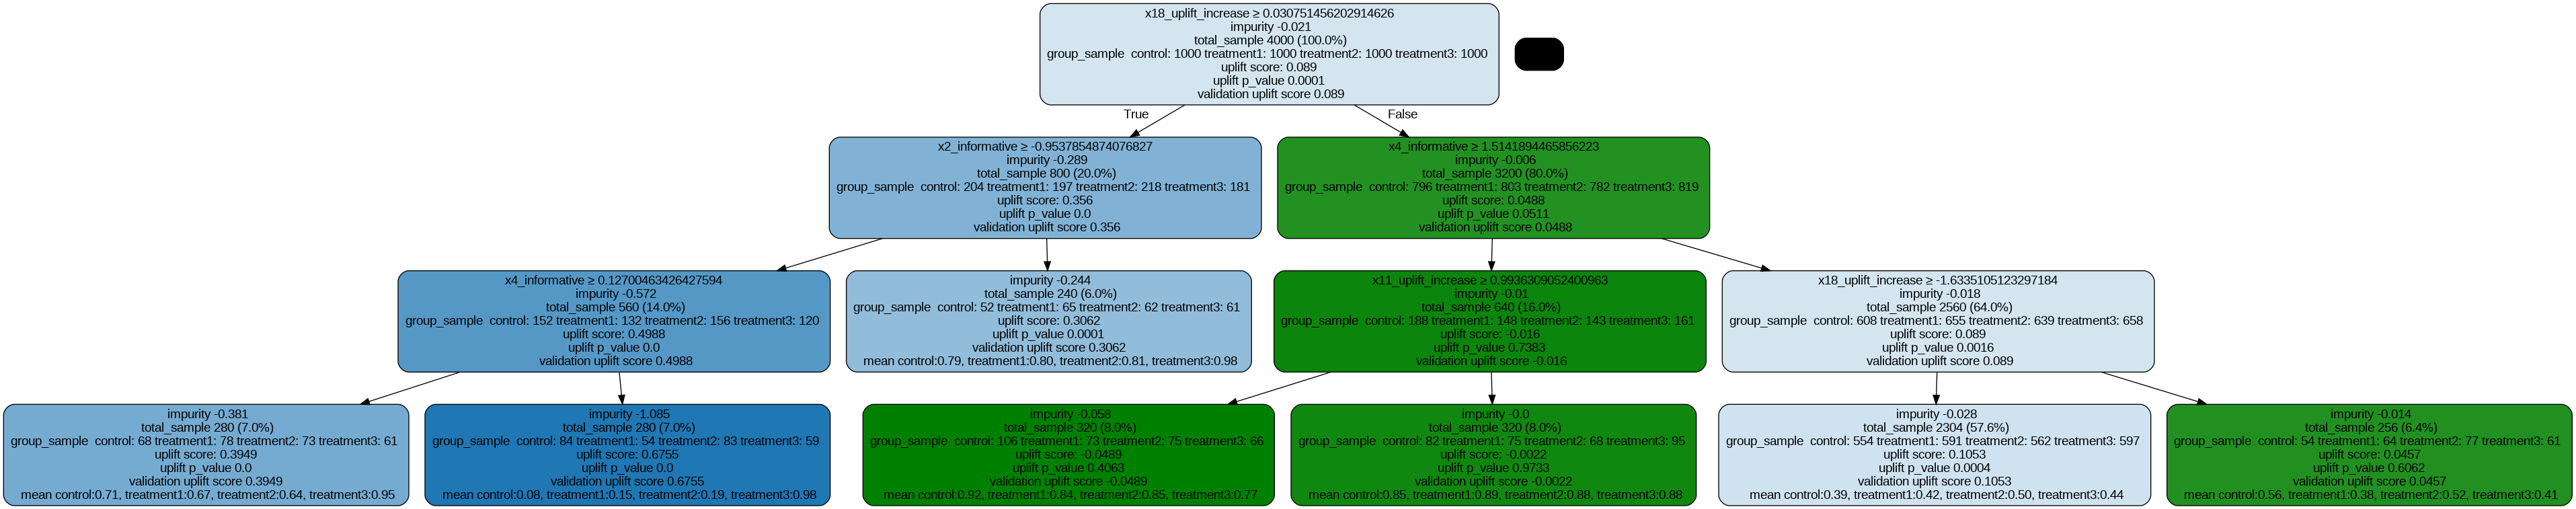

In [13]:
from IPython.display import Image

tree_graph = uplift_tree_plot(uplift_tree.fitted_uplift_tree, x_names_ex)
Image(tree_graph.create_png())

### 1-2. Uplift Random Forest Classifier

In [14]:
df_train_ex['treatment_group_key'].value_counts()

,count
treatment_group_key,
treatment2,813
control,811
treatment3,803
treatment1,773


In [15]:
uplift_rf = UpliftRandomForestClassifier(control_name='control')

uplift_rf.fit(df_ex[x_names_ex].values,
              treatment=df_ex['treatment_group_key'].values,
              y=df_ex['conversion'].values)

df_res_ex = uplift_rf.predict(df_test_ex[x_names_ex].values)

In [16]:
df_res_ex.shape

(800, 3)

In [17]:
df_res_ex

array([[ 0.01936152,  0.113854  ,  0.04281584],
       [-0.0622892 ,  0.01896113, -0.07114236],
       [-0.00687141,  0.04242801, -0.0069592 ],
       ...,
       [ 0.03104289,  0.05271873,  0.02175149],
       [-0.06903334, -0.0224079 , -0.04371949],
       [-0.02628378,  0.00774047, -0.05110898]])

In [18]:
result_ex = pd.DataFrame(df_res_ex, columns=uplift_rf.classes_[1:])
result_ex.head()

,treatment1,treatment2,treatment3
0,0.019362,0.113854,0.042816
1,-0.062289,0.018961,-0.071142
2,-0.006871,0.042428,-0.006959
3,-0.009823,0.034813,0.551714
4,-0.017492,-0.038440,0.303850


### 1-3. Uplift Curve

In [19]:
# If all deltas are negative, assing to control; otherwise assign to the treatment
# with the highest delta
best_treatment = np.where((result_ex < 0).all(axis=1),
                           'control',
                           result_ex.idxmax(axis=1))

# Create indicator variables for whether a unit happened to have the
# recommended treatment or was in the control group
actual_is_best = np.where(df_test_ex['treatment_group_key'] == best_treatment, 1, 0)
actual_is_control = np.where(df_test_ex['treatment_group_key'] == 'control', 1, 0)

In [20]:
synthetic = (actual_is_best == 1) | (actual_is_control == 1)
synth = result_ex[synthetic]

In [21]:
auuc_metrics = (synth.assign(is_treated = 1 - actual_is_control[synthetic],
                             conversion = df_test_ex.loc[synthetic, 'conversion'].values,
                             uplift_tree = synth.max(axis=1))
                     .drop(columns=list(uplift_rf.classes_[1:])))

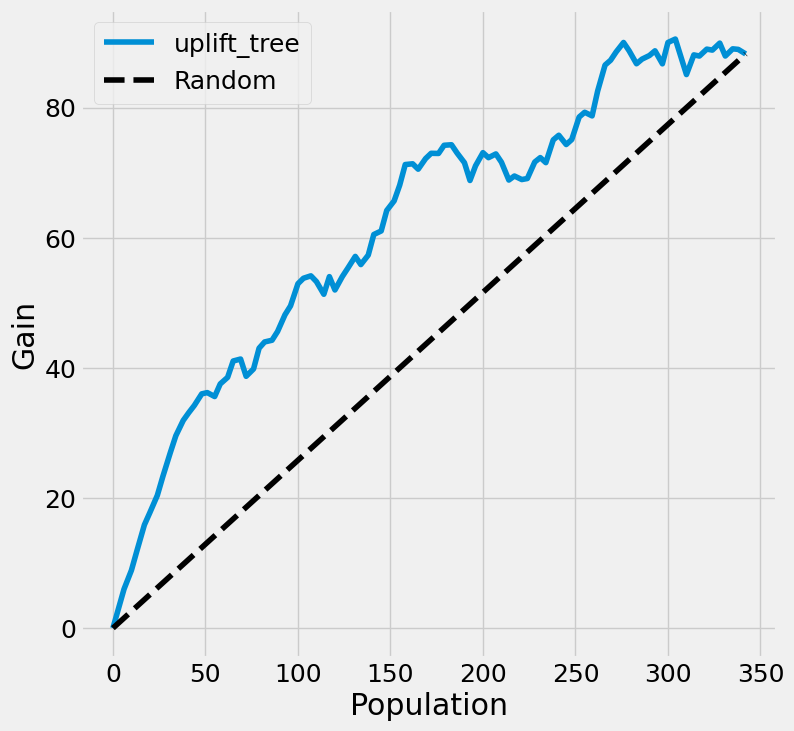

In [22]:
plot_gain(auuc_metrics, outcome_col='conversion', treatment_col='is_treated')

random에 비해서 처치, 통제 중 더 높은 uplift를 보이는 쪽을 선택하도록 했더니 전체적인 누적 gain이 늘어남.

## **2. criteo 광고 데이터를 이용한 uplift tree 모델**

In [23]:
df = pd.read_csv("hf://datasets/criteo/criteo-uplift/criteo-research-uplift-v2.1.csv.gz")

In [24]:
df.shape

(13979592, 16)

In [25]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 13979592 entries, 0 to 13979591
Data columns (total 16 columns):
 #   Column      Dtype  
---  ------      -----  
 0   f0          float64
 1   f1          float64
 2   f2          float64
 3   f3          float64
 4   f4          float64
 5   f5          float64
 6   f6          float64
 7   f7          float64
 8   f8          float64
 9   f9          float64
 10  f10         float64
 11  f11         float64
 12  treatment   int64  
 13  conversion  int64  
 14  visit       int64  
 15  exposure    int64  
dtypes: float64(12), int64(4)
memory usage: 1.7 GB


광고 타겟 대상인지를 구분하는 하나의 treatment만 존재함

In [26]:
df.describe()

,f0,f1,f2,f3,f4,f5,f6,f7,f8,f9,f10,f11,treatment,conversion,visit,exposure
count,1.397959e+07,1.397959e+07,1.397959e+07,1.397959e+07,1.397959e+07,1.397959e+07,1.397959e+07,1.397959e+07,1.397959e+07,1.397959e+07,1.397959e+07,1.397959e+07,1.397959e+07,1.397959e+07,1.397959e+07,1.397959e+07
mean,1.962030e+01,1.006998e+01,8.446582e+00,4.178923e+00,1.033884e+01,4.028513e+00,-4.155356e+00,5.101765e+00,3.933581e+00,1.602764e+01,5.333396e+00,-1.709672e-01,8.500001e-01,2.916680e-03,4.699200e-02,3.063122e-02
std,5.377464e+00,1.047557e-01,2.993161e-01,1.336645e+00,3.433081e-01,4.310974e-01,4.577914e+00,1.205248e+00,5.665958e-02,7.018975e+00,1.682288e-01,2.283277e-02,3.570713e-01,5.392748e-02,2.116217e-01,1.723164e-01
min,1.261636e+01,1.005965e+01,8.214383e+00,-8.398387e+00,1.028053e+01,-9.011892e+00,-3.142978e+01,4.833815e+00,3.635107e+00,1.319006e+01,5.300375e+00,-1.383941e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
25%,1.261636e+01,1.005965e+01,8.214383e+00,4.679882e+00,1.028053e+01,4.115453e+00,-6.699321e+00,4.833815e+00,3.910792e+00,1.319006e+01,5.300375e+00,-1.686792e-01,1.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
50%,2.192341e+01,1.005965e+01,8.214383e+00,4.679882e+00,1.028053e+01,4.115453e+00,-2.411115e+00,4.833815e+00,3.971858e+00,1.319006e+01,5.300375e+00,-1.686792e-01,1.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
75%,2.443646e+01,1.005965e+01,8.723335e+00,4.679882e+00,1.028053e+01,4.115453e+00,2.944427e-01,4.833815e+00,3.971858e+00,1.319006e+01,5.300375e+00,-1.686792e-01,1.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
max,2.674526e+01,1.634419e+01,9.051962e+00,4.679882e+00,2.112351e+01,4.115453e+00,2.944427e-01,1.199840e+01,3.971858e+00,7.529502e+01,6.473917e+00,-1.686792e-01,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00


In [27]:
# 전체에서 처치 집단의 비율 - 85%
df['treatment'].value_counts(normalize=True)

,proportion
treatment,
1,0.85
0,0.15


처치를 받은 대상자가 훨씬 많이 들어있는 데이터셋이다.

처치 여부가 '광고 타겟팅 대상인지'였고, 따라서 통제 집단에 대해서는 광고에 대한 exposure가 0이었던 것.

다만 처치 집단에 대해서도 실제 광고에 노출된 비율은 3% 정도라는 것에 유의해야겠다.

### 2-0. EDA

uplift model을 적용하기 전에 간단한 EDA를 해보자.

In [28]:
print(f"conversion rate: {df['conversion'].mean():.4f}")
print(f"visit rate: {df['visit'].mean():.4f}")
print(f"exposure rate: {df['exposure'].mean():.4f}")

conversion rate: 0.0029
visit rate: 0.0470
exposure rate: 0.0306


In [29]:
# 처치 여부에 따른 conversion, visit, exposure의 비율을 소수점 4자리까지만
df[['treatment', 'conversion', 'visit', 'exposure']].groupby('treatment').mean().round(4)

,conversion,visit,exposure
treatment,,,
0,0.0019,0.0382,0.000
1,0.0031,0.0485,0.036


처치 집단의 전환 비율이 통제 집단에 비해 1.5배 가량 높고, 방문율도 1.3배 정도 높다.

**Q. exposure 변수를 어떻게 봐야 할까? 타겟팅 광고 대상이었지만 그 중 3% 만이 실제로 광고를 봤다는 뜻일까?  그럼 타겟 광고 대상이었지만 결국 광고에 노출되지 않은 나머지 97%의 전환율은 어떻게 해석해야 할까?**

광고 노출 > 방문 > 전환 순서라면 다시 노출된 유저 중 얼만큼이 방문과 전환이 되었는지 퍼널을 볼 필요가 있다.

In [30]:
# exposure > visit funnel
df[['exposure','visit']][df['exposure']==1].groupby('exposure').agg({'visit': ['mean',  'sum', 'count']})

visit                
              mean     sum   count
exposure                          
1         0.414538  177510  428212

In [31]:
# visit > conversion funnel
df[['exposure', 'visit','conversion']][(df['exposure']==1) & (df['visit']==1)]\
    .groupby('visit')\
    .agg({'conversion': ['mean',  'sum', 'count']})

conversion               
            mean    sum   count
visit                          
1       0.129745  23031  177510

In [32]:
# 전체에서 conversion된 비율과 수치
df.agg({'conversion': ['mean',  'sum', 'count']})

,conversion
mean,2.916680e-03
sum,4.077400e+04
count,1.397959e+07


treatment -> exposure -> visit -> conversion로 가는 퍼널의 비율은 각각 0.04, 0.41, 0.13 정도..

### 2-1. Uplift Tree classifier





그대로 학습시킬 경우 처치와 통제 집단이 0.95:0.15로 클래스 불균형이 심해 통제집단에 오버피팅될 가능성이 있어보인다.

전체 데이터셋의 양 자체가 1300만여개이고 통제 집단의 수만 봐도 몇백만 수준으로, 학습시키기에는 충분해 보이기 때문에 더 양이 많은 처치그룹을 일부만 사용하도록 언더샘플링 하자.

train set에만 샘플링 하기 위해 train/test 를 먼저 분리하자.

In [33]:
df_train, df_test = train_test_split(
    df,
    test_size=0.2,
    random_state=42,
    stratify=df['treatment']
    )

In [34]:
# 전체 중 train, test 8:2로 나눴을 때 개수 - train:1118만, test: 279만
print(len(df_train), len(df_test))

# train set에 속하는 샘플 중 treatment group, control group의 수
print(df_train['treatment'].value_counts())


11183673 2795919
treatment
1    9506123
0    1677550
Name: count, dtype: int64


control group의 크기가 167만 정도니까 거기에 맞춰서 treatment group을 언더샘플링 하면 될 것 같다.

In [35]:
# treatment=1인 그룹에 대해서만 treatment=0인 그룹과 같은 수만큼 샘플링
df_treatment_sampled = df_train[df_train['treatment']==1].sample(len(df_train[df_train['treatment']==0]))

# 샘플링한 처치집단을 통제집단과 concat해서 처치집단/통제집단의 크기가 같은 새로운 train data를 만듦
df_train_resampled = pd.concat([df_train[df_train['treatment']==0], df_treatment_sampled], axis=0)

# 처치/통제집단에 속하는지 여부의 하나의 컬럼 안에서 'control', 'treatment'라는 값으로 바꿔줘야 함
df_train_resampled['treatment'] = df_train_resampled['treatment'].astype(str).replace({'0': 'control', '1': 'treatment'})
df_test['treatment'] = df_test['treatment'].astype(str).replace({'0': 'control', '1': 'treatment'})

In [36]:
df_train_resampled['treatment'].value_counts()

,count
treatment,
control,1677550
treatment,1677550


In [37]:
df_test['treatment'].value_counts()

,count
treatment,
treatment,2376532
control,419387


In [38]:
df_train_resampled['treatment'].unique()

array(['control', 'treatment'], dtype=object)

In [39]:
# 새로운 처치/통제집단의 크기가 같아졌는지 확인
df_train_resampled['treatment'].value_counts()

,count
treatment,
control,1677550
treatment,1677550


In [40]:
x_names = df_train_resampled.columns
print(x_names)
x_names = [x for x in df_train_resampled.columns if x not in ['treatment', 'conversion','visit','exposure']]
print(x_names)


Index(['f0', 'f1', 'f2', 'f3', 'f4', 'f5', 'f6', 'f7', 'f8', 'f9', 'f10',
       'f11', 'treatment', 'conversion', 'visit', 'exposure'],
      dtype='object')
['f0', 'f1', 'f2', 'f3', 'f4', 'f5', 'f6', 'f7', 'f8', 'f9', 'f10', 'f11']


In [41]:
# uplift tree classifier를 초기화하고 언더샘플링된 학습데이터를 모델에 피팅
clf = UpliftTreeClassifier(max_depth=5, min_samples_leaf=100, evaluationFunction='KL', control_name='control')

clf.fit(df_train_resampled[x_names], # ndarray of the covariates used to train the uplift model
        treatment=df_train_resampled['treatment'].values, # treatment: array containing the treatment group for each unit
        y=df_train_resampled['conversion'].values) # y: array containint the outcome of interest for each unit

pred_tree_outcome = clf.predict(df_test[x_names].values)
pred_tree_df = pd.DataFrame(pred_tree_outcome, columns=clf.classes_, index=df_test.index)
pred_tree_df.head()

,control,treatment
6304619,0.001114,0.002745
4045638,0.001114,0.002745
5767216,0.000118,0.000176
9668584,0.001616,0.003101
830405,0.000118,0.000176


In [42]:
x_names

['f0', 'f1', 'f2', 'f3', 'f4', 'f5', 'f6', 'f7', 'f8', 'f9', 'f10', 'f11']

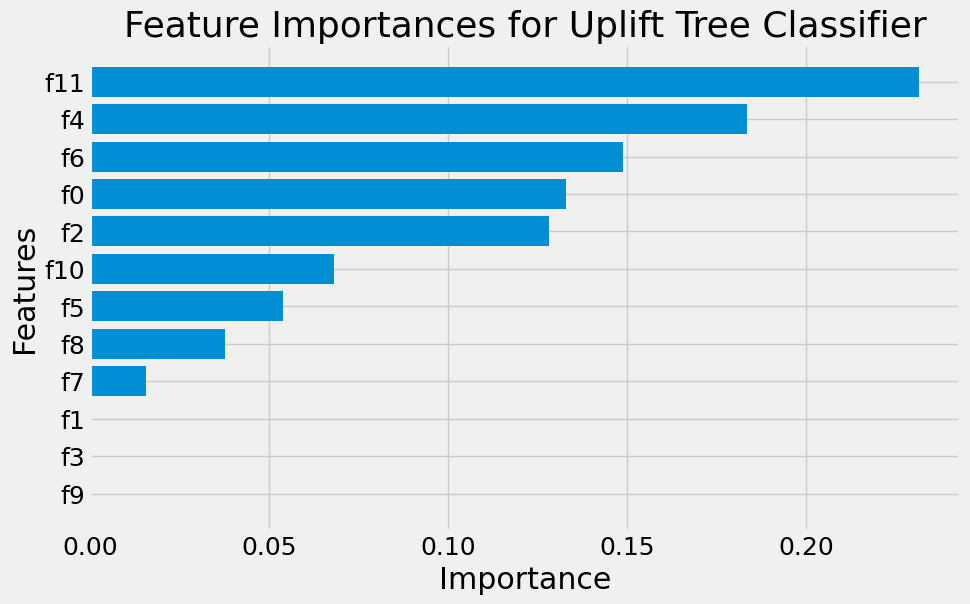

In [43]:
# 피쳐 중요도
import warnings
warnings.filterwarnings('ignore')

feature_importances = pd.Series(clf.feature_importances_, index=x_names)

feature_importances_sorted = feature_importances.sort_values(ascending=False)

plt.figure(figsize=(10, 6))
plt.barh(feature_importances_sorted.index, feature_importances_sorted.values)
plt.xlabel("Importance")
plt.ylabel("Features")
plt.title("Feature Importances for Uplift Tree Classifier")
plt.gca().invert_yaxis()
plt.show()



상위 5개 피쳐(f11, f4, f5, f0, f2)가 다른 변수들에 비해 전환에 예측에 대해 높은 영향을 미치는 편. f1,3,7,9 등은 정확히 어떤 변수냐에 따라 다르지만 위의 그래프에 따르면 전환과 크게 관련성이 없는 요소인 듯하므로 학습 시 제외할 수 있을 것 같다.

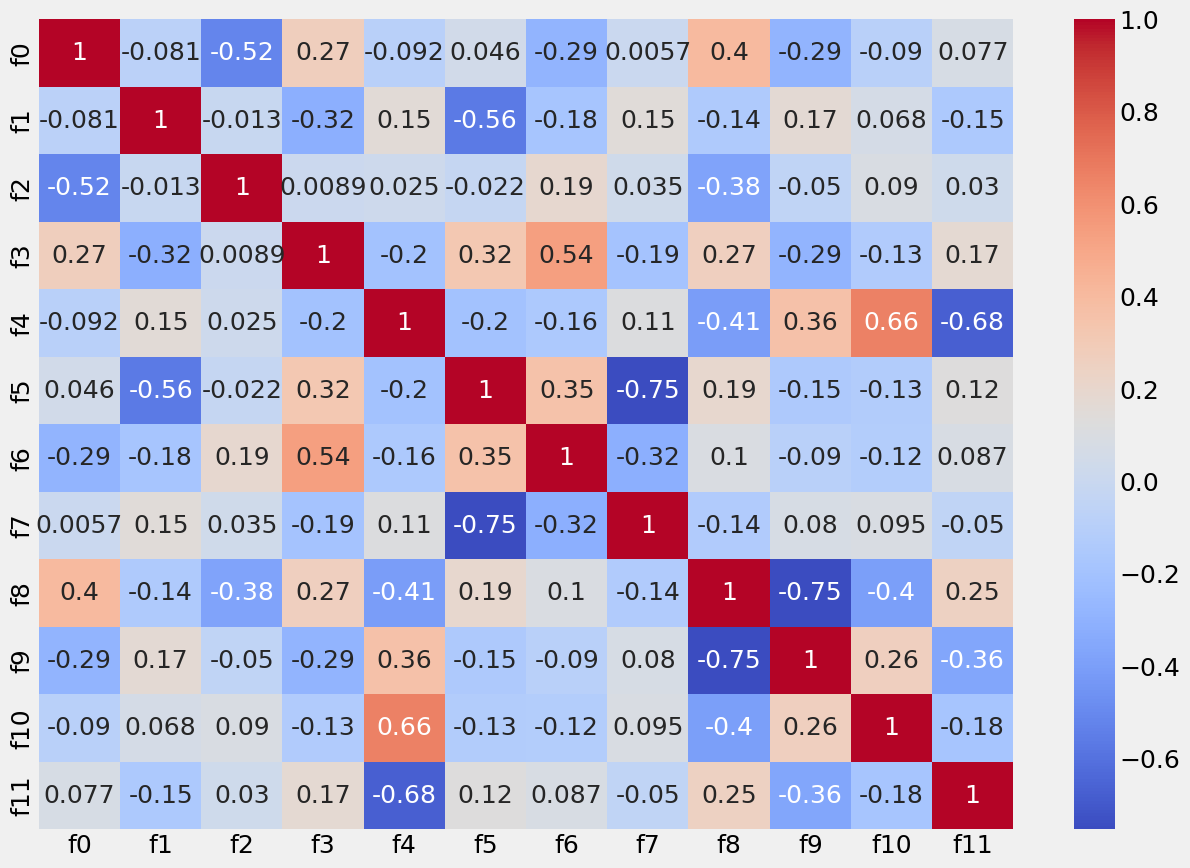

In [44]:
# f2, f6가 중복이 되는 변수일 가능성을 확인하기 위해 피어슨 상관관계 heatmap
import seaborn as sns

plt.figure(figsize=(14, 10))
sns.heatmap(df_train_resampled[x_names].corr(), annot=True, cmap='coolwarm')
plt.show()

피쳐 중요도가 높은 변수들 중에는 f4가 f10과는 양의 상관이, f11과는 음의 상관이 있는 편이라(반면 f10, f11은 상관이 낮음) f4를 제외하는 방식으로 중복을 줄이는 것을 고려해볼 만하다.

In [45]:
# 예측 결과의 원래 형태: 샘플 수 x (처치 수 +1) ndarray
pred_tree_outcome

array([[0.00111406, 0.00274532],
       [0.00111406, 0.00274532],
       [0.00011774, 0.00017573],
       ...,
       [0.00016795, 0.00019434],
       [0.00085664, 0.00093889],
       [0.00111406, 0.00274532]])

In [46]:
# 직접 uplift score 계산
pred_tree_df['uplift_score'] = pred_tree_df['treatment'] - pred_tree_df['control']
pred_tree_df.head(10)

,control,treatment,uplift_score
6304619,0.001114,0.002745,0.001631
4045638,0.001114,0.002745,0.001631
5767216,0.000118,0.000176,0.000058
9668584,0.001616,0.003101,0.001485
830405,0.000118,0.000176,0.000058
13072218,0.001114,0.002745,0.001631
6684440,0.000168,0.000194,0.000026
8177366,0.000118,0.000176,0.000058
711358,0.000118,0.000176,0.000058
617415,0.000118,0.000176,0.000058


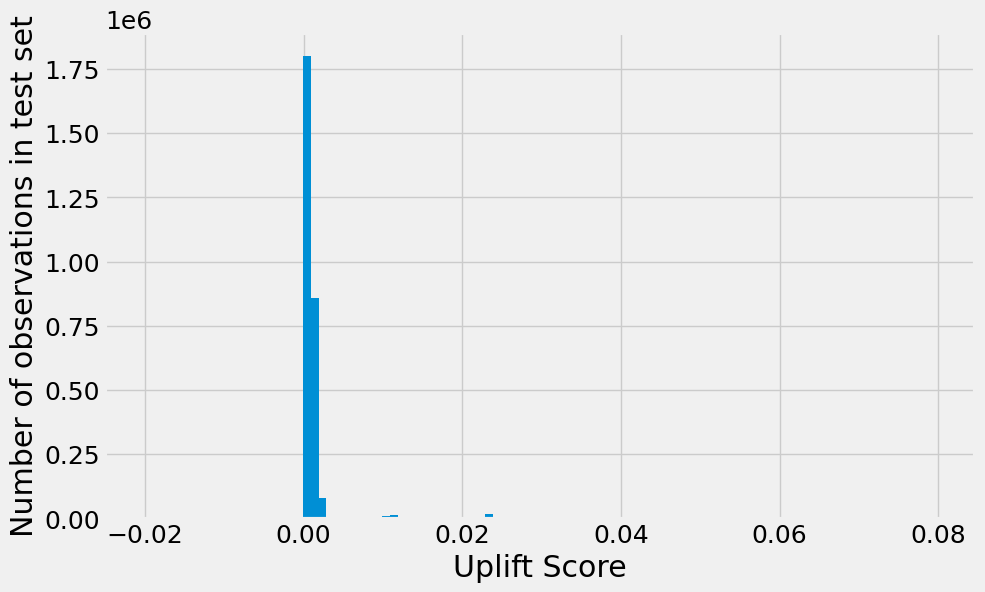

In [47]:
# 여기서부터 다시. 샘플별로 처치로 인해 얻은 incremental gain을 histogram으로 확인하고 싶음
plt.figure(figsize=(10,6))
plt.hist(pred_tree_df['uplift_score'], bins=100)
plt.xlabel("Uplift Score")
plt.ylabel("Number of observations in test set")
plt.show()

In [48]:
for col in pred_tree_df.columns:
    print(f"{col}: ", pred_tree_df[col].nunique())

control:  15
treatment:  16
uplift_score:  16


뭔가 이상하다.. 여러 샘플들에 대해 예측된 control, treatment의 값이 너무 비슷하다. ?

### 2-2. Uplift Random Forest Classifier


In [49]:
x_names

['f0', 'f1', 'f2', 'f3', 'f4', 'f5', 'f6', 'f7', 'f8', 'f9', 'f10', 'f11']

In [50]:
uplift_rf = UpliftRandomForestClassifier(max_depth=5, min_samples_leaf=100, control_name='control')

uplift_rf.fit(df_train_resampled[x_names].values,
              treatment=df_train_resampled['treatment'].values,
              y=df_train_resampled['conversion'].values)

pred_rf = uplift_rf.predict(df_test[x_names].values, full_output=True)
print(pred_rf.shape)
pred_rf.head()

(2795919, 5)


,control,treatment,recommended_treatment,delta_treatment,max_delta
0,0.001825,0.003077,1,0.001252,0.001252
1,0.001886,0.003282,1,0.001396,0.001396
2,0.001357,0.002285,1,0.000929,0.000929
3,0.001252,0.002569,1,0.001318,0.001318
4,0.001357,0.002285,1,0.000929,0.000929


> If `full_output` is `True`, a DataFrame containing the predicted outcome of each treatment and control group, the treatment effect of each treatment group, the treatment group with the
highest treatment effect, and the maximum treatment effect for each sample.

- recommended_treatment: 예측된 uplift score가 가장 높은 처치
- delta_treatment: uplift score
- (처치가 여럿인 경우) 가장 높은 uplift score



### 2-3. Uplift Curve


In [51]:
# Calculate the uplift score from the prediction results
pred_rf['uplift_score'] = pred_rf['treatment'] - pred_rf['control']

# Create a DataFrame with the necessary columns for plot_gain
criteo_auuc_metrics = pred_rf.assign(
    is_treated = df_test['treatment'].apply(lambda x: 1 if x == 'treatment' else 0).values,
    conversion = df_test['conversion'].values,
    # Rename uplift_tree to uplift_score as required by plot_gain
    uplift_score = pred_rf['uplift_score']
)
print(criteo_auuc_metrics.head())

    control  treatment  recommended_treatment  delta_treatment  max_delta  \
0  0.001825   0.003077                      1         0.001252   0.001252   
1  0.001886   0.003282                      1         0.001396   0.001396   
2  0.001357   0.002285                      1         0.000929   0.000929   
3  0.001252   0.002569                      1         0.001318   0.001318   
4  0.001357   0.002285                      1         0.000929   0.000929   

   uplift_score  is_treated  conversion  
0      0.001252           0           0  
1      0.001396           1           0  
2      0.000929           0           0  
3      0.001318           1           0  
4      0.000929           1           0  


In [52]:
criteo_auuc_metrics.groupby('is_treated')['conversion'].value_counts(normalize=True)

is_treated  conversion
0           0             0.998100
            1             0.001900
1           0             0.996864
            1             0.003136
Name: proportion, dtype: float64

처치 그룹에서의 전환율은 0.31%, 통제 그룹에서의 전환율은 약 0.19%

In [53]:
criteo_auuc_metrics[['conversion', 'is_treated', 'uplift_score']]

,conversion,is_treated,uplift_score
0,0,0,0.001252
1,0,1,0.001396
2,0,0,0.000929
3,0,1,0.001318
4,0,1,0.000929
...,...,...,...
2795914,0,1,-0.002139
2795915,0,1,0.001175
2795916,0,1,0.001295
2795917,0,1,0.000470


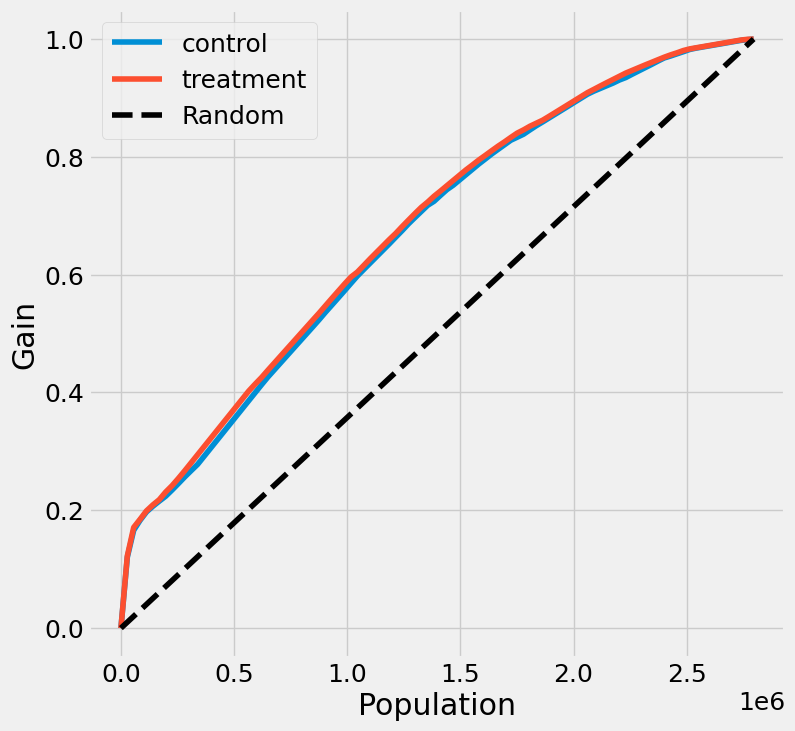

In [54]:
# Plot the uplift curve
plot_gain(criteo_auuc_metrics[['conversion', 'is_treated', 'uplift_score', 'control', 'treatment']],
          outcome_col='conversion',
          treatment_col='is_treated',
          treatment_effect_col='uplift_score',
          normalize=True
          )
plt.show()

control과 treatment의 커브는 크게 차이 나지 않음. 모델이 conversion 자체의 확률은 어느정도 구분하지만 처치에 따른 uplift는 잘 구분하지 못하고 있음.

혹시 데이터를 언더샘플링 한 것이 오히려 모델이 전체 데이터의 분포를 왜곡해서 문제가 되었을 수도 있으니 언더샘플링 없이 원래의 학습데이터를 그대로 사용해보자.

In [55]:
df_train['treatment']

,treatment
11807573,1
10202691,1
5009192,1
7062114,1
3700276,1
...,...
7519902,1
6204409,0
383158,1
11984976,1


In [ ]:
# Convert the 'treatment' column in df_train to string type with 'control' and 'treatment' values
df_train['treatment'] = df_train['treatment'].astype(str).replace({'0': 'control', '1': 'treatment'})

uplift_rf_clf = UpliftRandomForestClassifier(max_depth=5,
                                             n_estimators=5, # 커널이 자꾸 죽어버려서 tree 개수 줄임(default:10 )
                                             min_samples_leaf=50,
                                             control_name='control') # Changed control_name to 'control' to match the string values

uplift_rf_clf.fit(df_train[x_names].values,
              treatment=df_train['treatment'].values,
              y=df_train['conversion'].values)

pred_result = uplift_rf_clf.predict(df_test[x_names].values, full_output=True)
print(pred_result.shape)
pred_result.head()

전체 데이터로는 코랩에서 램이 모자라서 돌아가지 않는다는 결론...